In [1]:
setwd("/hpc/hub_oudenaarden/agiladi/data/tuft_release/")

In [2]:
set.seed(1111)

library(metacell)
library(RColorBrewer)

library(clusterProfiler)
library(ChIPpeakAnno) # for turning symbols into EntrezID
library(org.Hs.eg.db)

library(ggrepel)
library(flowCore)
library(flowWorkspace)

library(Hmisc)

source("release_code/metacell_functions.r")

scdb_init("saved_work", force=T)


Warning message:
“namespace ‘cachem’ is not available and has been replaced
by .GlobalEnv when processing object ‘’”
Bioconductor version '3.10' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install
Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
clusterProfiler v3.14.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.
Loading required package: grid
Loading required package: IRanges
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, cl

In [3]:
outdir = "release_figures/fig2_organoids/"
dir.create(outdir)

Warning message in dir.create(outdir):
"'release_figures/fig2_organoids' already exists"

Load metacell objects and create environment

In [4]:
id = "ileum_organoids"

suffix = ""; id_f = paste0(id, suffix)
sc_2d = scdb_mc2d(id); sc_cl = scdb_mc(paste0(id, suffix)); sc_mat = scdb_mat(id)

cells = names(sc_cl@mc)
cell_stats = sc_mat@cell_metadata[cells,]
colnames(cell_stats) = gsub(" ", ".", colnames(cell_stats))
colnames(cell_stats) = gsub("\\(|\\)", "_", colnames(cell_stats))
fp = sc_cl@mc_fp
lfp = log2(sc_cl@mc_fp)

color_scheme = sc_cl@color_key
color2name = as.vector(color_scheme$group); names(color2name) = color_scheme$color
name2color = as.vector(color_scheme$color); names(name2color) = color_scheme$group
sc_names = color2name[ sc_cl@colors[ sc_cl@mc]]; names(sc_names) = names(sc_cl@mc)
annotations = as.matrix(read.delim(paste0("release_import/figure2_cs2//lin_ord_", id, ".txt"), stringsAsFactor=F, h=F))[,1]
lin_ord = annotations


In [5]:
message(length(cells), " cells")
message(length(table(sc_cl@mc)), " metacells")
write.table(lin_ord, quote=F, row.names=F, col.names=F)

953 cells
16 metacells


Stem cells
Goblet cells-1
Goblet cells-2
Tuft-1
Tuft-2
Tuft-3
Tuft-4


In [6]:
good_cells = sample(rownames(cell_stats)[ cell_stats$source == "Ileum"])

png 
  2

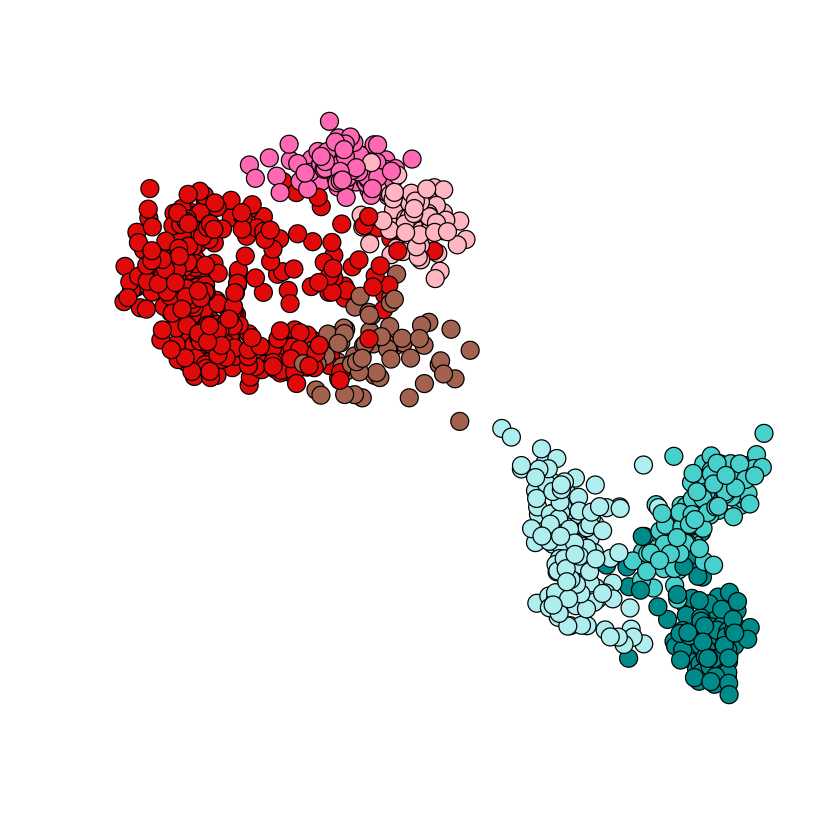

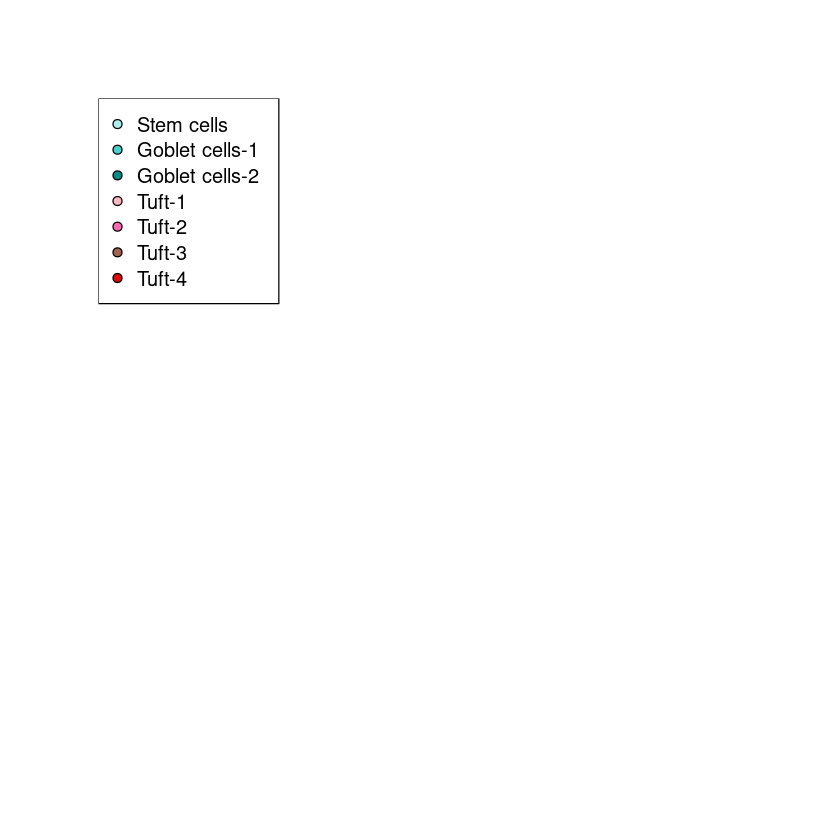

In [7]:
all_cells = intersect(names(sc_2d@sc_x), names(sc_cl@mc))

p = function() {
    plot(sc_2d@sc_x[all_cells], sc_2d@sc_y[all_cells], pch = 20, col = "gray",
        axes = F, xlab = "", ylab = "", cex = 1)
    points(sc_2d@sc_x[good_cells], sc_2d@sc_y[good_cells], pch = 21, bg = sc_cl@colors[ sc_cl@mc[good_cells]], cex=2)
}

p()
pdf(paste0(outdir, "/Fig2b.pdf"), useDingbats=F, height=10, width=10)
p()
dev.off()

plot.empty()
legend("topleft", lin_ord, pch=21, pt.bg = name2color[ lin_ord])


In [8]:
tuft_pops = grep("Tuft", lin_ord, v=T)
tuft_mc = which(color2name[ sc_cl@colors] %in% tuft_pops)
tuft_cells = intersect(names(sc_names)[ sc_names %in% tuft_pops], rownames(cell_stats)[ cell_stats$gating == "AVIL-Clover+"])

In [9]:
comb = paste0(ifelse(sc_names[good_cells] %in% tuft_pops, "Tuft", "Epithel"), "@", cell_stats[ good_cells, "treatment"])
names(comb) = good_cells
cols = c("gray40", "gray90", "darkorange2", "antiquewhite")

png 
  2

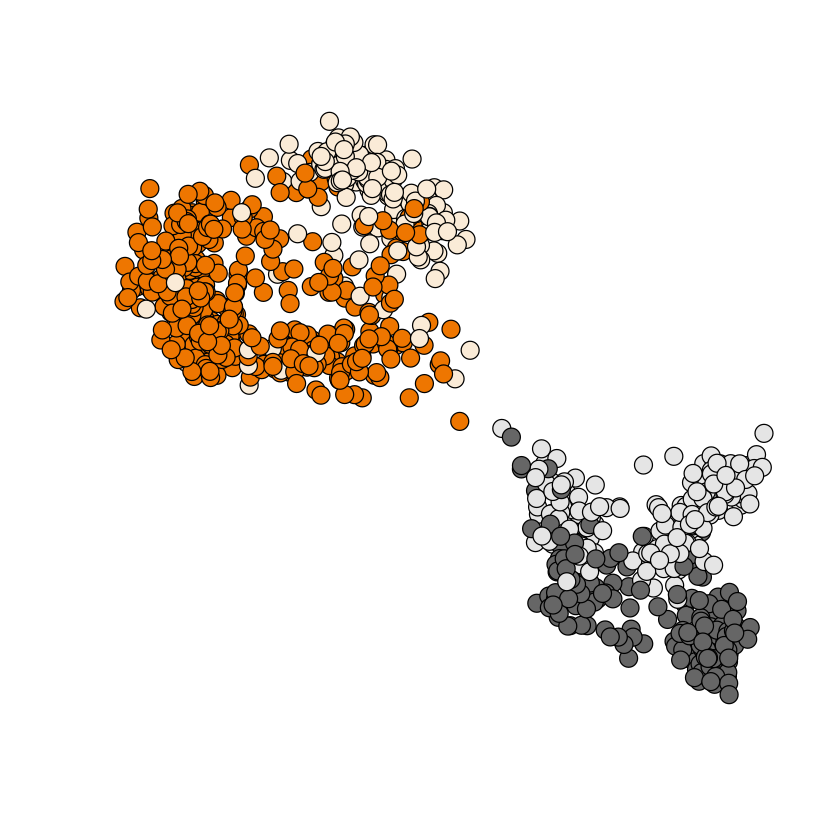

In [10]:
p = function() {
    plot(sc_2d@sc_x[all_cells], sc_2d@sc_y[all_cells], pch = 20, col = "gray",
        axes = F, xlab = "", ylab = "", cex = 1)
    points(sc_2d@sc_x[good_cells], sc_2d@sc_y[good_cells], pch = 21, cex = 2, bg = cols[ as.numeric(factor(comb[good_cells]))])
}

p()
pdf(paste0(outdir, "/Fig2a.pdf"), useDingbats=F, height=10, width=10)
p()
dev.off()


In [11]:
sample_dist = table(factor(cell_stats[ tuft_cells, "treatment"], levels = c("no_cyto", "IL4+IL13")), sc_names[ tuft_cells])
sample_dist = sample_dist[, intersect(lin_ord, colnames(sample_dist))]
summarize.table(sample_dist)

,Tuft-1,Tuft-2,Tuft-3,Tuft-4,total
no_cyto,59,79,7,28,173
IL4+IL13,14,13,57,316,400
total,73,92,64,344,573


In [12]:
dist_n = sample_dist / rowSums(sample_dist)


bconf = sapply(colnames(sample_dist), function(c)
    binconf(sample_dist[,c], rowSums(sample_dist))) * 100

pointEst = bconf[1:2,]; dimnames(pointEst) = dimnames(dist_n)
lower = bconf[3:4,]
upper = bconf[5:6,]


png 
  2

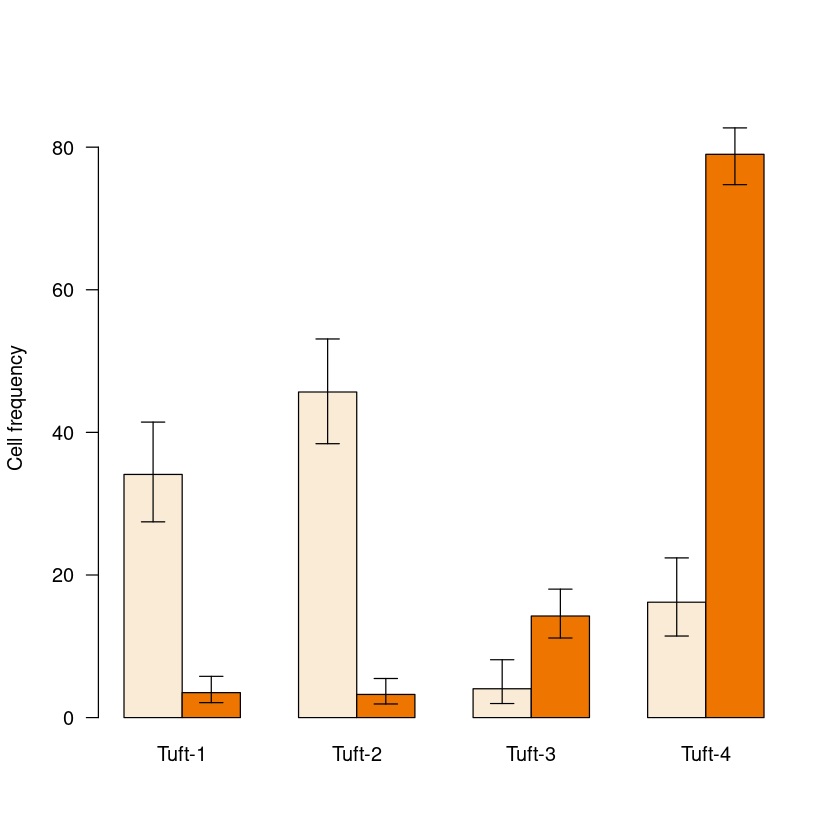

In [13]:
#par(mar = c(10,7,3,1))

p = function(){
    coords = barplot(pointEst, beside=T, axes = F, ylab = "Cell frequency", ylim = c(0, 1.05 * max(upper)),
        col = c("antiquewhite", "darkorange2"))
    axis(2, las = 2)
    segments(coords, lower, y1 = upper)
    segments(coords - 0.2, lower, coords + 0.2)
    segments(coords - 0.2, upper, coords + 0.2)
}

p()
pdf(paste0(outdir, "/Fig2d.pdf"), useDingbats = F, height=5, width=7)
p()
dev.off()



In [14]:
umis = read_large_umis(id, cells = good_cells)
umis_n = sweep(umis, 2, cell_stats[ good_cells, "umicount"], "/") * 1000

In [15]:
clust_ord = setdiff(order(factor(color2name[ sc_cl@colors], levels = lin_ord)), c())

In [16]:
comb = ifelse(sc_names[ good_cells] %in% tuft_pops, sc_names[ good_cells], "Epithel")
names(comb) = good_cells

m = t(apply(umis_n[names(which(rowSums(umis[,good_cells]) > 50)), good_cells], 1, tapply, comb[ good_cells], mean))
m = m[, names(which(table(comb[ good_cells]) > 20))]
message(nrow(m), " genes with >50 total UMI")

10706 genes with >50 total UMI


In [17]:
# Calculate fold changes against the epithelium non-tuft background

bg = "Epithel"
reg = 0.02
Z = log2((reg + m[,tuft_pops]) / (reg + m[,bg]))
diff_genes = sapply(tuft_pops, function(x) scr_chi_square_diff_genes(umis, g1 = names(which(comb == x)), g2 = names(which(comb == bg)), 
                                  pval = 0.01, fdr = T))                    

In [18]:
names(diff_genes) = paste0(names(diff_genes), "@")
diff_genes = unlist(diff_genes)
diff_genes = table(diff_genes, vecsplit(names(diff_genes), "@", 1))

In [19]:
shared = intersect(rownames(diff_genes), rownames(Z))
core_genes = names(which(rowSums(diff_genes[shared,] == 1 & Z[ shared, colnames(diff_genes)] > 1) == ncol(diff_genes)))

In [20]:
shared = intersect(rownames(diff_genes), rownames(Z))
double_genes = diff_genes[shared,] == 1 & Z[ shared, colnames(diff_genes)] > 1

png 
  2

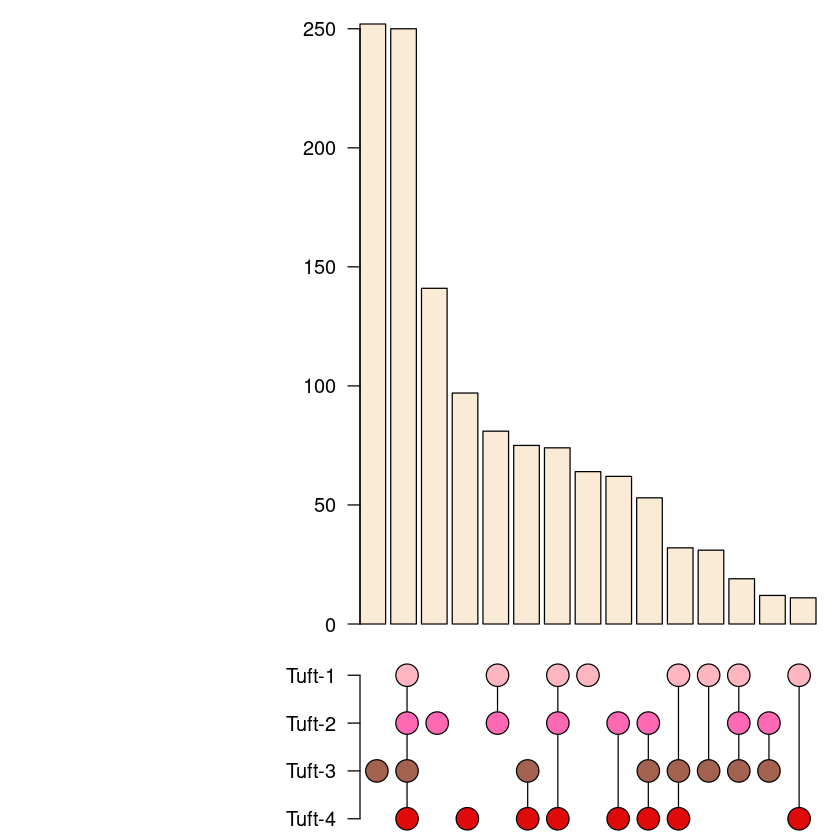

In [21]:
p = function() {
    X = apply(double_genes[ rowSums(double_genes) > 0,], 1, function(x) paste0(colnames(double_genes)[ x], collapse = ","))
    Y = sort(table(X), T)

    par (mar = c(0, 15, 1, 1), fig = c(0,1,0.25,1))          
    coords = barplot(Y, names.arg = rep("", length(Y)), las=2, xaxs="i", col = "antiquewhite")

    Z = strsplit(names(Y), ",")
    names(Z) = paste0(seq_along(Z), "@")
    Z = unlist(Z)
    X = t(table(as.numeric(vecsplit(names(Z), "@", 1)), factor(Z, levels = rev(tuft_pops))))

    par(fig = c(0,1,0,0.25), new=T)  
    hmed = seq(0, 1, length.out = nrow(X))
    vmed = seq(min(coords), max(coords), length.out = ncol(X))
    cex_val = X * 2.5
    plot(1,1,type="n", xlim = quantile(coords, c(0,1)), ylim = c(-0.1, 1.1), axes = F, xlab = "", ylab = "")          
    invisible(sapply(as.numeric(colnames(X)), function(x) lines(rep(vmed[x], sum(X[,x])), hmed[which(X[,x] == 1)]))) 
    points(rep(vmed, each = nrow(X)), rep(hmed, ncol(X)), pch = 21, 
        bg = name2color[ rep(rownames(X), ncol(X))], cex = cex_val, xlab = "", ylab = "",# xaxs="i",
        xlim = quantile(coords, c(0,1)), ylim = c(-0.1, 1.1))
    axis(2, at = hmed, labels = rownames(X), las = 2)

    
}
                     
p()
                     
pdf(paste0(outdir, "/ExtFig4f.pdf"), height=4, width=7, useDingbats = F)
p()
dev.off()


In [22]:
core_genes = names(which(rowSums(!double_genes) == 0))
disp_genes = union(names(head(sort(apply(Z[core_genes,],1, min), T), 20)), c("GNAT3","AVIL"))

zlim: 0<>1
zlim: 0<>1


png 
  2

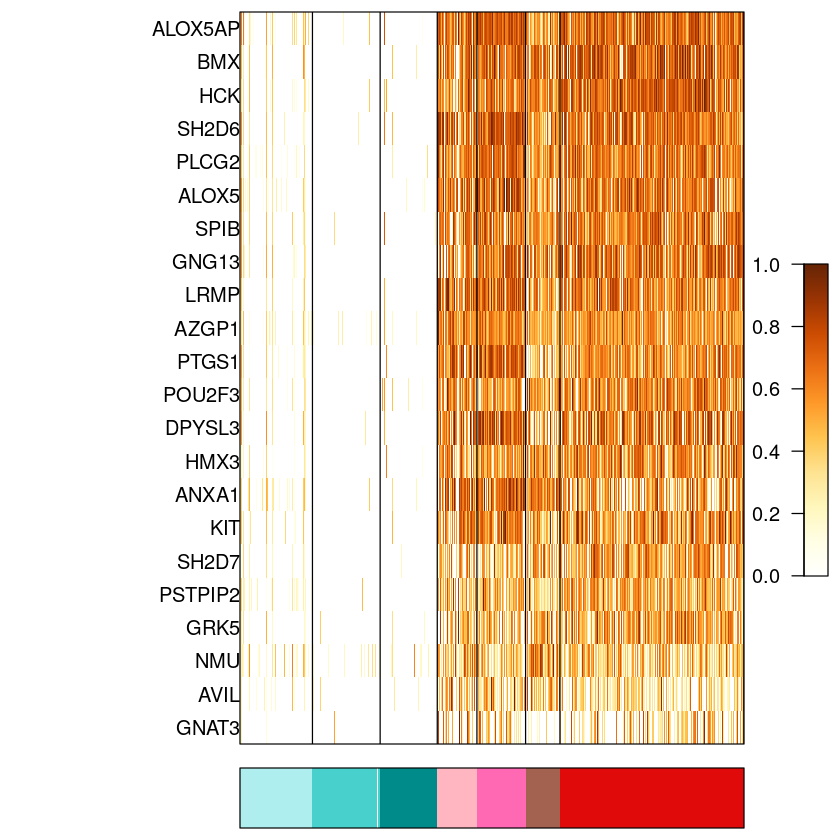

In [23]:
grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(1000)
IM = log(1 + 7 * umis_n[ disp_genes,])
IM = IM / apply(IM, 1, quantile, 0.999)
IM = pmin(IM, 1)


vct = factor(sc_names[colnames(IM)], levels = lin_ord); names(vct) = colnames(IM)
good_pops = names(which(table(vct) > 20))
IM = IM[, vct[colnames(IM)] %in% good_pops]
vct = factor(vct[ colnames(IM)], levels = good_pops); names(vct) = colnames(IM)
IM = IM[,names(sort(vct[ colnames(IM)]))]; IM = IM[ order(rowSums(IM)),]
p = function() {
    par(mar = c(0.5, 10, 0.5, 0.5), fig = c(0,0.9,0.1,1))
    image.2(IM, b=F, vct=vct[ colnames(IM)], col=grad, annotate="rows"); box()
    par(fig = c(0,0.9,0,0.1), new=T)
    image(matrix(seq_along(colnames(IM))), axes=F, col = sc_cl@colors[ sc_cl@mc[ colnames(IM)]]); box()
    par(fig = c(0.9,1,0.3,0.7), new=T, mar = c(0.5,2,0.5,0.5))
    image(y = seq(min(IM), max(IM), length.out = length(grad)), t(seq_along(grad)), col=grad, axes=F)
    axis(2,las=2)
    box()
}

p()
pdf(paste0(outdir, "/Fig2c.pdf"), height=10, width=10, useDingbats = F)
p()
dev.off()

## Analyze gene expression differences between the tuft cell states

In [24]:
within_genes = sapply(tuft_pops, function(x) scr_chi_square_diff_genes(umis, g1 = names(which(comb == x)), g2 = names(comb)[comb %in% setdiff(tuft_pops, x)], 
                                  pval = 0.01, fdr = T))
names(within_genes) = paste0(names(within_genes), "@")
within_genes = unlist(within_genes)
within_genes = table(within_genes, vecsplit(names(within_genes), "@", 1))


In [25]:
Z2 = log2((reg + m[,tuft_pops]) / (reg + apply(m[,tuft_pops], 1, median)))
shared = intersect(rownames(within_genes), rownames(Z2))

In [26]:
double_within = within_genes[shared,] == 1 & Z2[ shared, colnames(within_genes)] > 1

In [27]:
double_within = double_within[ rowSums(double_within) > 0,]
genes = union(rownames(double_within), core_genes)
gene_anno = rep("Core", length(genes)); names(gene_anno) = genes
gene_anno[ rownames(double_within)] = colnames(double_within)[ max.col(double_within)]

In [28]:
rel_genes = names(gene_anno)[ gene_anno %in% c("Core", paste0("Tuft-", 1:4))]

df = data.frame(round(Z2[rel_genes,],3), anno = gene_anno[ rel_genes], umicount = rowSums(umis[rel_genes, tuft_cells ]), mean_count = rowMeans(umis_n[rel_genes, tuft_cells ]))
X = df[ order(df$anno, df$umicount),]

In [29]:
good_genes = intersect(names(gene_anno), names(which(apply(Z,1,max) > 1)))
gene_score = rowSums(umis[good_genes, tuft_cells]) #apply(Z[good_genes,], 1, function(x) mean(x[ x > 1]))

disp_genes = setdiff(read.table("release_import/for_figures/Fig2e_heatmap_genes.txt", stringsAsFactors = F)[[1]], "ALOX5AP")

zlim: 0<>1
zlim: 0<>1


png 
  2

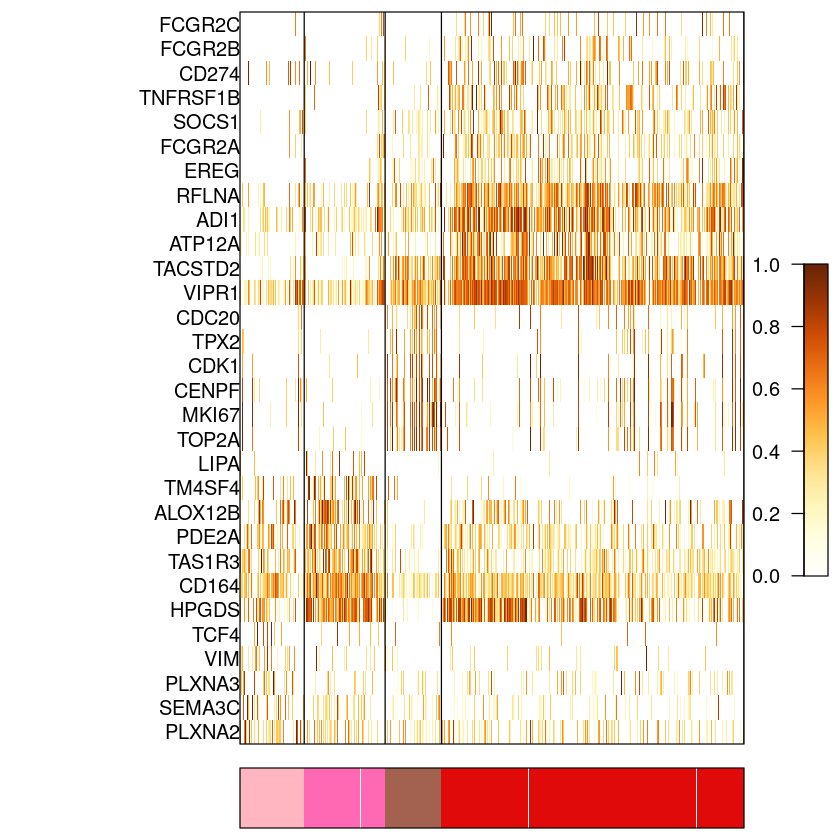

In [30]:
grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(1000)
IM = log(1 + 7 * umis_n[ disp_genes, tuft_cells])
IM = IM[, order(factor(sc_cl@mc[ colnames(IM)], levels = clust_ord))]
IM = IM / apply(IM, 1, quantile, 0.999)
IM = pmin(IM, 1)

vct = factor(sc_names[colnames(IM)], levels = lin_ord); names(vct) = colnames(IM)
good_pops = names(which(table(vct) > 20))
IM = IM[, vct[colnames(IM)] %in% good_pops]
vct = factor(vct[ colnames(IM)], levels = good_pops); names(vct) = colnames(IM)
IM = IM[,names(sort(vct[ colnames(IM)]))]; 
IM = IM[ order(max.col(Z[ rownames(IM),]), -rowSums(umis[ rownames(IM), tuft_cells])),]
p = function(IM) {
    par(mar = c(0.5, 10, 0.5, 0.5), fig = c(0,0.9,0.1,1))
    image.2(IM, b=F, vct=vct[ colnames(IM)], col=grad, annotate="rows"); box()
    par(fig = c(0,0.9,0,0.1), new=T)
    image(matrix(seq_along(colnames(IM))), axes=F, col = sc_cl@colors[ sc_cl@mc[ colnames(IM)]]); box()
    par(fig = c(0.9,1,0.3,0.7), new=T, mar = c(0.5,2,0.5,0.5))
    image(y = seq(min(IM), max(IM), length.out = length(grad)), t(seq_along(grad)), col=grad, axes=F)
    axis(2,las=2)
    box()
}

p(IM)
pdf(paste0(outdir, "/Fig2e.pdf"), height=10, width=10, useDingbats = F)
p(IM)
dev.off()


In [31]:
grad = colorRampPalette(c("gray90", "gray90", brewer.pal(3, "Reds")))(101)

plot_feature_maps = function(i, genes, nr = 2, nc = 3, rfac = 5) {
    cb = 1 / nc
    rb = 1 / nr
    locs = cbind(rep(seq_len(nc) - 1, nr), rep(rev(seq_len(nr)) - 1, each = nc))
    gene = genes[i]
    all_cells = names(sort(umis_n[gene, good_cells]))
    vals = umis_n[gene, good_cells]
    all_cells = names(sort(vals))
    pos_vals = log(1 + 1 * vals[ vals > 0])
    pos_vals = pmin(pos_vals, quantile(pos_vals, 0.99))
    val_n = rep(1, length(all_cells)); names(val_n) = all_cells
    val_n[ names(pos_vals)] = round(100 * pos_vals / max(pos_vals)) + 1
    cell_ord = names(val_n) #sort(val_n))
    r = locs[i,2]; c = locs[i,1]
    par(fig = c(c / nc, c / nc + cb * 0.85, r / nr, r / nr + rb * 0.85), mar = rep(0.5,4), new = (i > 1))
    df = cbind(x = sc_2d@sc_x[ all_cells], y = sc_2d@sc_y[ all_cells], col = grad[ val_n[ all_cells]], 
               rx = round(sc_2d@sc_x[ all_cells] / rfac), ry = round(sc_2d@sc_y[ all_cells] / rfac))
    df = df[ !duplicated(df[, c("col", "rx", "ry")]),]
    dim(df)
    plot(df[,"x"], df[,"y"], pch = 20, cex = 1, col = df[,"col"], axes = F, xlab = "", ylab = "", main = gene)
    par (fig = c(c / nc + cb * 0.9, c / nc + cb * 1, r / nr + rb * 0.3, r / nr + rb * 0.6), new=T)
    ax = seq(0, max(pos_vals), length.out = length(grad))
    image(y = ax, t(seq_along(grad)), axes = F, col = grad)
    box(); axis(2, at = quantile(ax, c(0,1)), labels = round(quantile(ax, c(0,1)),3), las = 2)
}


png 
  2

png 
  2

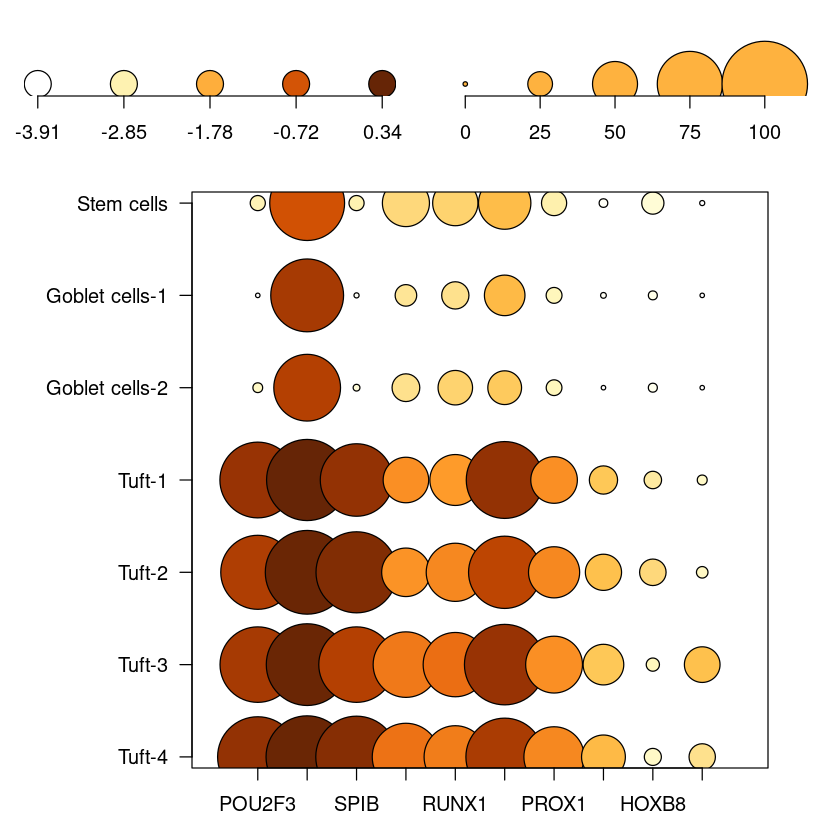

In [32]:

p = function() {
    grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(101)
    par(mar = c(3,8,1,3))
    matplot.2(t(IM), t(exp_freq), grad=grad, cex_lim = seq(0,100, by = 25))
}


genes = c("POU2F3", "SOX9", "SPIB", "TCF7", "RUNX1", "ZFHX3", "PROX1", "GFI1B", "HOXB8", "HMX2")

m = t(apply(umis_n[genes, good_cells], 1, tapply, sc_names[ good_cells], mean))
m = m[, rev(intersect(lin_ord, names(which(table(sc_names[ good_cells]) > 20))))]
IM = log(m + 0.02)
exp_freq = t(apply(umis[genes, good_cells] > 0, 1, tapply, sc_names[ good_cells], mean))
exp_freq = exp_freq[ ,colnames(m)] * 100

p()
pdf(paste0(outdir, "/ExtFig5a_left.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

pdf(paste0(outdir, "/ExtFig5a_right.pdf"), height=15, width=20, useDingbats=F)
invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 3, nc = 4))
dev.off()


png 
  2

png 
  2

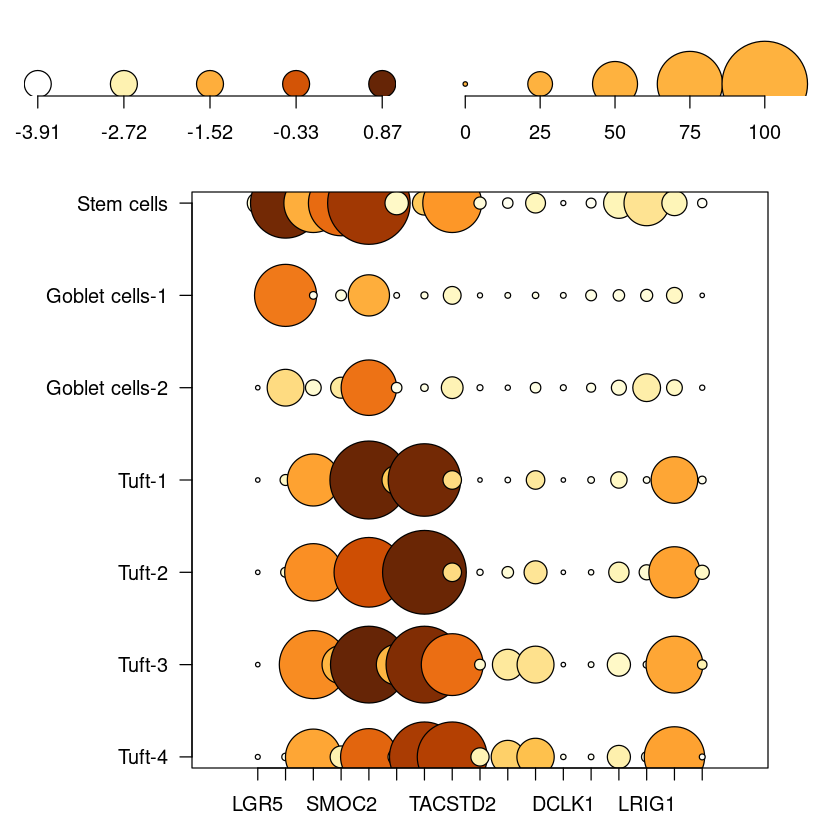

In [33]:
genes = c(read.table("release_import/for_figures/stem_genes.txt", stringsAsFactors = F)[[1]], c("DCLK1","TERT", "BMI1", "LRIG1", "PROX1", "CLU"))


m = t(apply(umis_n[genes, good_cells], 1, tapply, sc_names[ good_cells], mean))
m = m[, rev(intersect(lin_ord, names(which(table(sc_names[ good_cells]) > 20))))]
IM = log(m + 0.02)
exp_freq = t(apply(umis[genes, good_cells] > 0, 1, tapply, sc_names[ good_cells], mean))
exp_freq = exp_freq[ ,colnames(m)] * 100

p()
pdf(paste0(outdir, "/ExtFig8a_left.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

#invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 3, nc = 4))
pdf(paste0(outdir, "/ExtFig8a_right.pdf"), height=15, width=20, useDingbats=F)
invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 3, nc = 6))
dev.off()


png 
  2

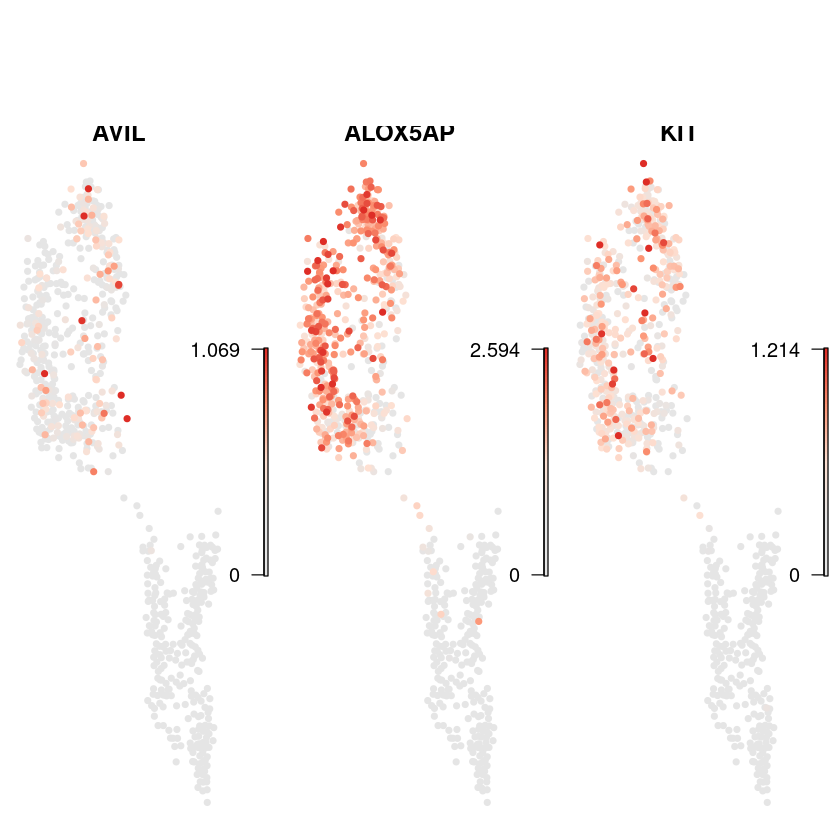

In [34]:
genes = c("AVIL", "ALOX5AP", "KIT")
invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 1, nc = 3))
pdf(paste0(outdir, "/ExtFig4e.pdf"), height=5, width=15, useDingbats=F)
invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 1, nc = 3))
dev.off()

## Perform GO enrichment analysis on tuft-1-4 genes

In [35]:
go_df = NULL
for (c in colnames(double_genes)) { 
    genes = names(which(double_genes[,c]))
    message("Annotation: ", c, " (", length(genes), " genes)")
    vec = convert2EntrezID(genes, "org.Hs.eg.db", ID_type="gene_symbol")
    gg_bp <- enrichGO(vec, OrgDb = "org.Hs.eg.db", pvalueCutoff=0.05, pAdjustMethod="BH", qvalueCutoff=0.2, readable=TRUE, ont= c("BP"))
    gg_mf <- enrichGO(vec, OrgDb = "org.Hs.eg.db", pvalueCutoff=0.05, pAdjustMethod="BH", qvalueCutoff=0.2, readable=TRUE, ont= c("MF"))
    Y = rbind(cbind(gg_bp@result, ont = "BP"), cbind(gg_mf@result, ont = "MF"))
    Y_genes = sapply(Y[,8], strsplit, "/")
    l = unlist(lapply(Y_genes, length))
    go_df = rbind(go_df, data.frame(gene = unlist(Y_genes), module = rep(Y$Description, l), 
        pval = rep(Y$p.adjust, l), length = rep(l, l), ID = rep(Y$ID, l), ont = rep(Y$ont, l), c=c))
}
head(go_df)


Annotation: Tuft-1 (562 genes)
Annotation: Tuft-2 (692 genes)
Annotation: Tuft-3 (724 genes)
Annotation: Tuft-4 (654 genes)


gene,module,pval,length,ID,ont,c
ACTR2,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
ALKAL1,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
ARHGAP4,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
AVIL,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
COBL,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
DAB1,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1


In [36]:
go_df2 = go_df[ go_df$length > 3 & go_df$pval < 0.05,]
go_df3 = unique(go_df2[, c("c", "ID", "module", "pval", "length")])


In [37]:
# go_df3 contains all the GO terms for the 4 populations.
# We fed go_df3 to the REIGO tool (http://revigo.irb.hr/) to condense the number of terms.

In [38]:
Revigo = read.delim("release_import/for_figures/Revigo.tsv", row.names=1, stringsAsFactors = F)
good_go = rownames(Revigo)[ Revigo$Eliminated == "False"]
black_list = c()
go_df2 = go_df[ go_df$ID %in% good_go &(!go_df$module %in% black_list),]
go_df3 = unique(go_df2[, c("c", "ID", "module", "pval", "length")])


In [39]:
temp = dcast(go_df3[,c("module", "c", "pval")], module ~ c)
go_pval = as.matrix(temp[,-1]); rownames(go_pval) = temp[,1]


Using pval as value column: use value.var to override.


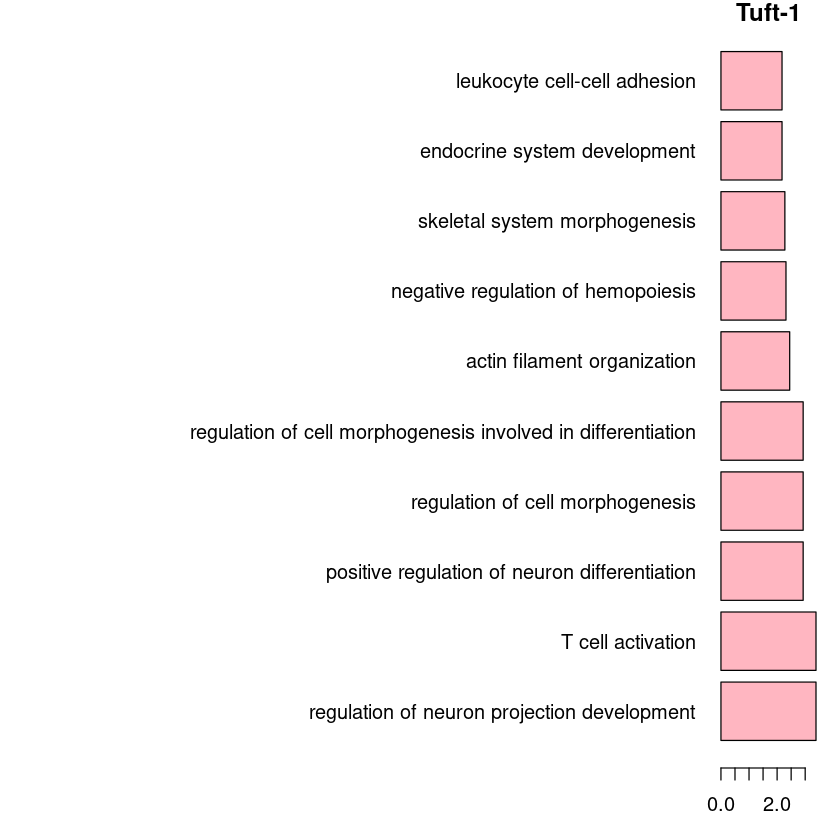

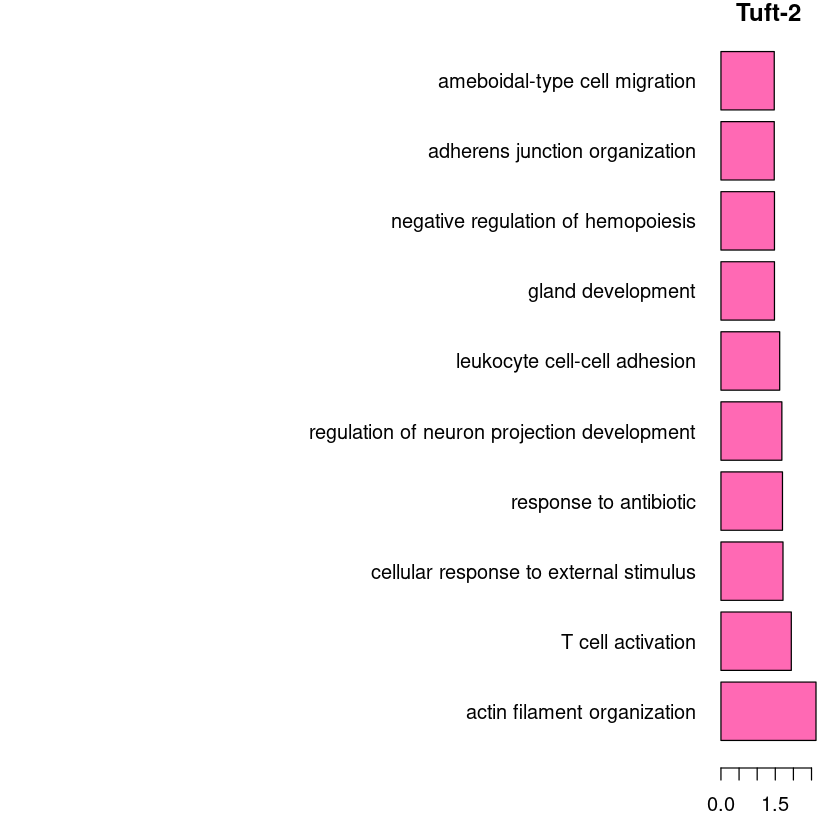

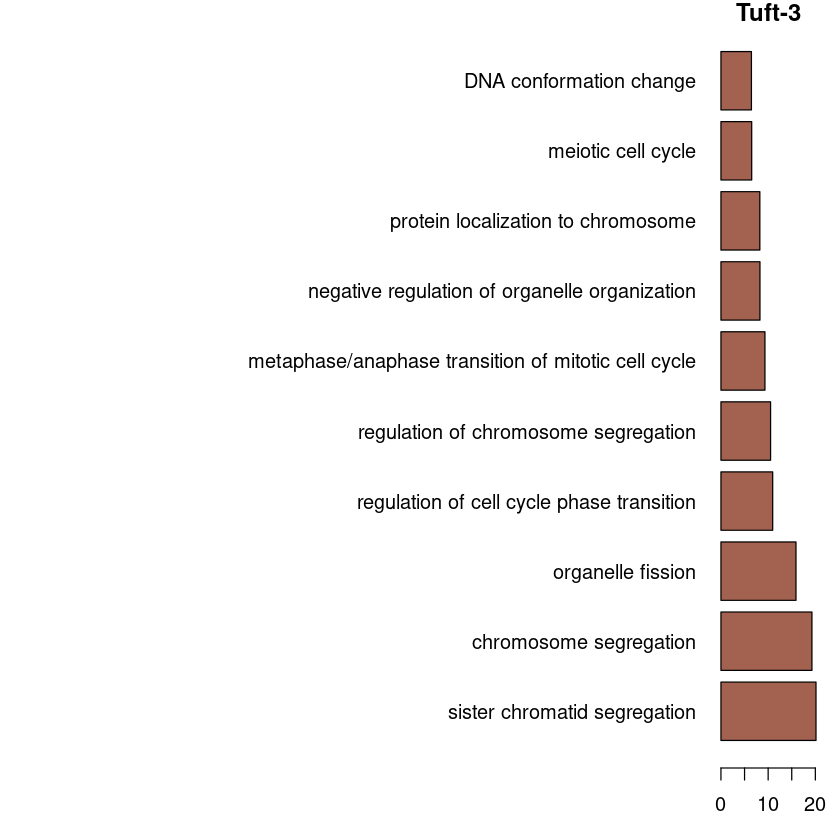

png 
  2

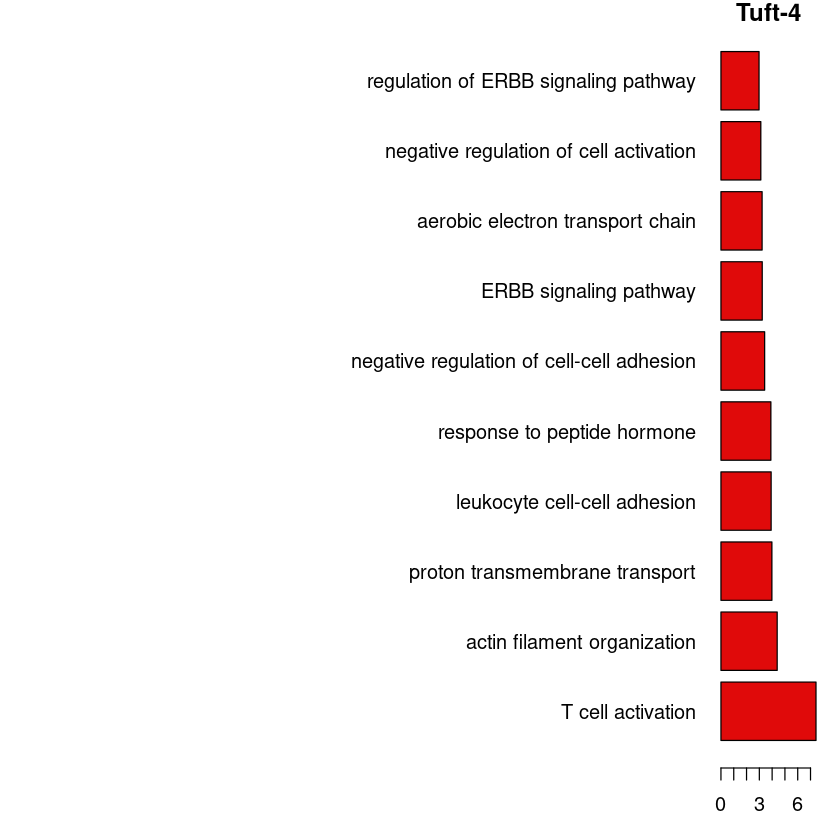

In [40]:
pvals_l = list()

p = function() {
    par(mar = c(3, 30, 1, 1))
    for (c in colnames(go_pval)) {
        pvals = head(sort(go_pval[,c]), 10)
        pvals = pvals[ pvals < 0.05]
        barplot(-log10(pvals), horiz = T, las = 2, axes=F, col = name2color[c])
        title(c); axis(1)
        pvals_l[[c]] = cbind(pvals, module = names(pvals), c)
    }
pvals_l
}

pvals_l = p()
pdf(paste0(outdir, "/ExtFig4g.pdf"), height=20, width=30)
par(mfrow=c(2,2))
invisible(p())
dev.off()

## tuft-3 vs. tuft-4 signature

In [41]:
tuft_genes = read.delim("release_import/for_figures/organoids_tuft_genes.txt", stringsAsFactors = F, row.names=1)

foc = log(1 + 7 * umis_n)
tuft4_genes = rownames(tuft_genes)[tuft_genes$anno == "Tuft-4"]
score4 = colSums(foc[ tuft4_genes,])

tuft3_genes = rownames(tuft_genes)[tuft_genes$anno == "Tuft-3"]
score3 = colSums(foc[ tuft3_genes,])


png 
  2

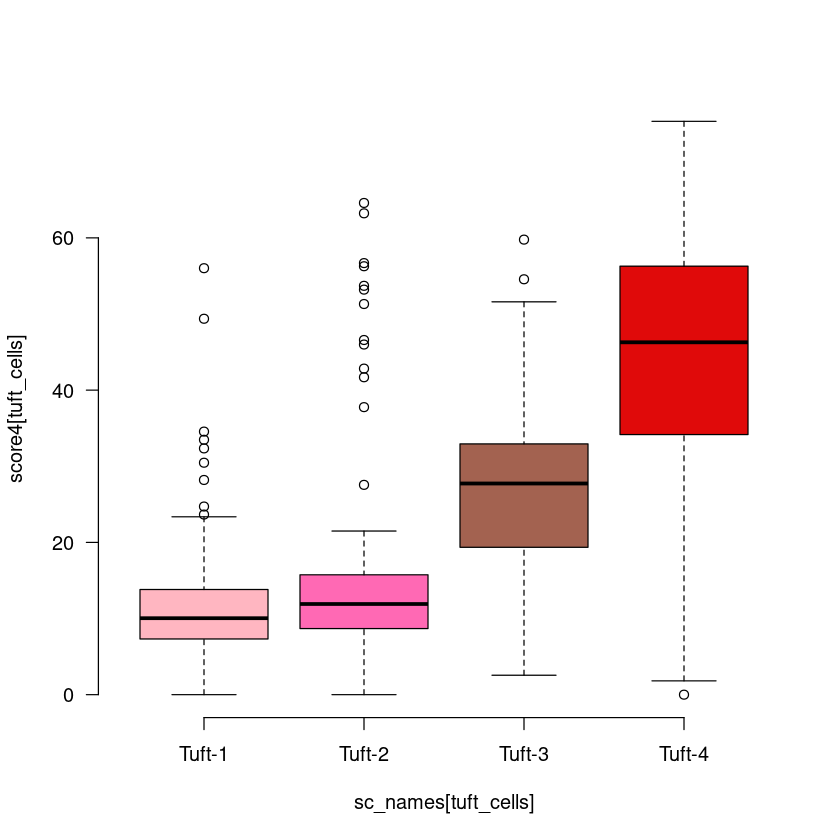

In [42]:
p = function() {
    boxplot(score4[ tuft_cells] ~ sc_names[ tuft_cells], col = name2color[ tuft_pops], axes = F)
    axis(2, las = 2); axis(1, at = seq_along(tuft_pops), labels = tuft_pops)
}

p()
pdf(paste0(outdir, "/ExtFig4o.pdf"), useDingbats = F)
p()
dev.off()


## Extended Data display items

In [43]:
lin_ord

[1] "Stem cells"     "Goblet cells-1" "Goblet cells-2" "Tuft-1"        
[5] "Tuft-2"         "Tuft-3"         "Tuft-4"

In [44]:
ep_pops = setdiff(lin_ord, tuft_pops)
ep_cells = names(sc_names)[ sc_names %in% ep_pops]
ep_mc = as.numeric(names(table(sc_cl@mc[ ep_cells])))

In [45]:
disp_genes = rev(read.table("release_import/for_figures//epithelial_genes_sc_heatmap.txt", stringsAsFactors = F)[[1]])

In [46]:
grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(1000)
IM = log(1 + 7 * umis_n[ disp_genes, ep_cells])

vct = factor(sc_names[colnames(IM)], levels = lin_ord); names(vct) = colnames(IM)
good_pops = names(which(table(vct) > 20))
IM = IM[, vct[colnames(IM)] %in% good_pops]
vct = factor(vct[ colnames(IM)], levels = good_pops); names(vct) = colnames(IM)
IM = IM[,names(sort(vct[ colnames(IM)]))]; 
#IM = IM[ order(max.col(Z2[ rownames(IM),])),]


IM = IM / apply(IM, 1, quantile, 0.999)
IM = pmin(IM, 1)

p = function() {
    par(mar = c(0.5, 10, 0.5, 0.5), fig = c(0,0.9,0.1,1))
    image.2(IM, b=F, vct=vct[ colnames(IM)], col=grad, annotate="rows"); box()
    par(fig = c(0,0.9,0,0.1), new=T)
    image(matrix(seq_along(colnames(IM))), axes=F, col = sc_cl@colors[ sc_cl@mc[ colnames(IM)]]); box()
    par(fig = c(0.9,1,0.3,0.7), new=T, mar = c(0.5,3,0.5,0.5))
    image(y = seq(min(IM), max(IM), length.out = length(grad)), t(seq_along(grad)), col=grad, axes=F)
    axis(2,las=2)
    box()
}

pdf(paste0(outdir, "/ExtFig4d.pdf"), useDingbats = F, height = 10, width = 10)
p()
dev.off()

zlim: 0<>1


png 
  2

In [47]:
cell_stats = sc_mat@cell_metadata
cell_stats = cell_stats[ cell_stats$source == "Ileum" & cell_stats$type == "organoid",]
dim(cell_stats)


[1] 1532   11

png 
  2

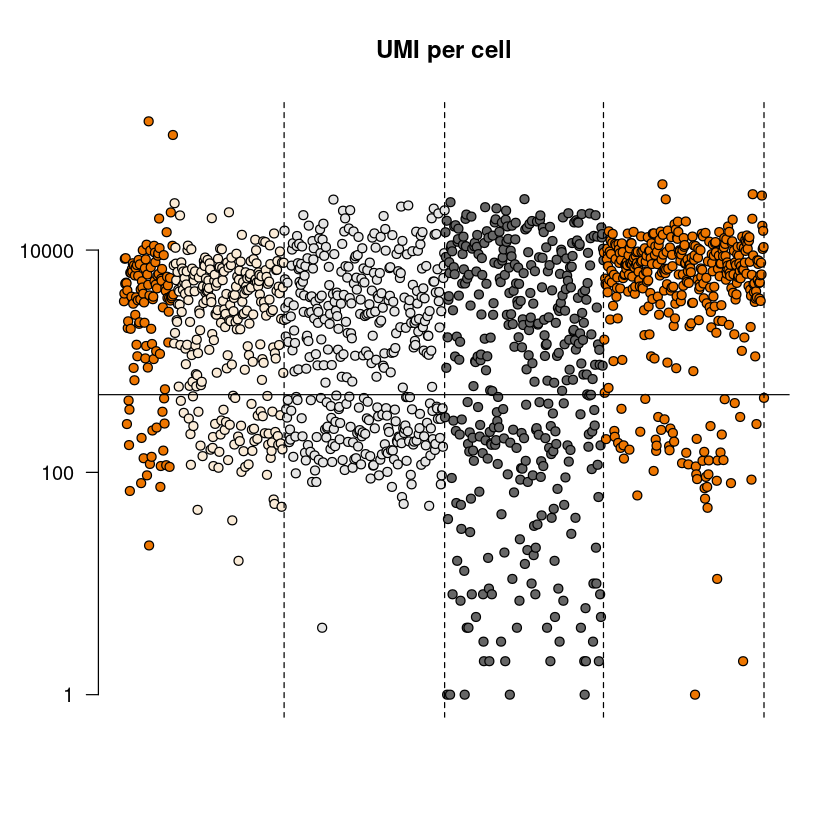

In [48]:
cls = cumsum(table(as.vector(cell_stats$amp_batch_id)))

comb = paste0(cell_stats$gating, "@", cell_stats$treatment)
names(comb) = rownames(cell_stats)

cols = c("darkorange2", "antiquewhite", "gray40", "gray90"); names(cols) = names(table(comb))

p = function() {
    cell_stats = cell_stats[ order(cell_stats$amp_batch_id, cell_stats$gating, cell_stats$treatment),]
    plot(cell_stats$umicount, log="y", pch = 21, bg = cols[ comb[ rownames(cell_stats)]], axes = F, ylab = "", xlab = "", main = "UMI per cell")
    abline(v = cls, lty = 2)
    abline(h = 500); axis(2, las = 2)
}

p()
pdf(paste0(outdir, "/ExtFig4c.pdf"), useDingbats = F)
p()
dev.off()

# To calculate Extended Data Fig. 4c left, we will need to download the raw data

png 
  2

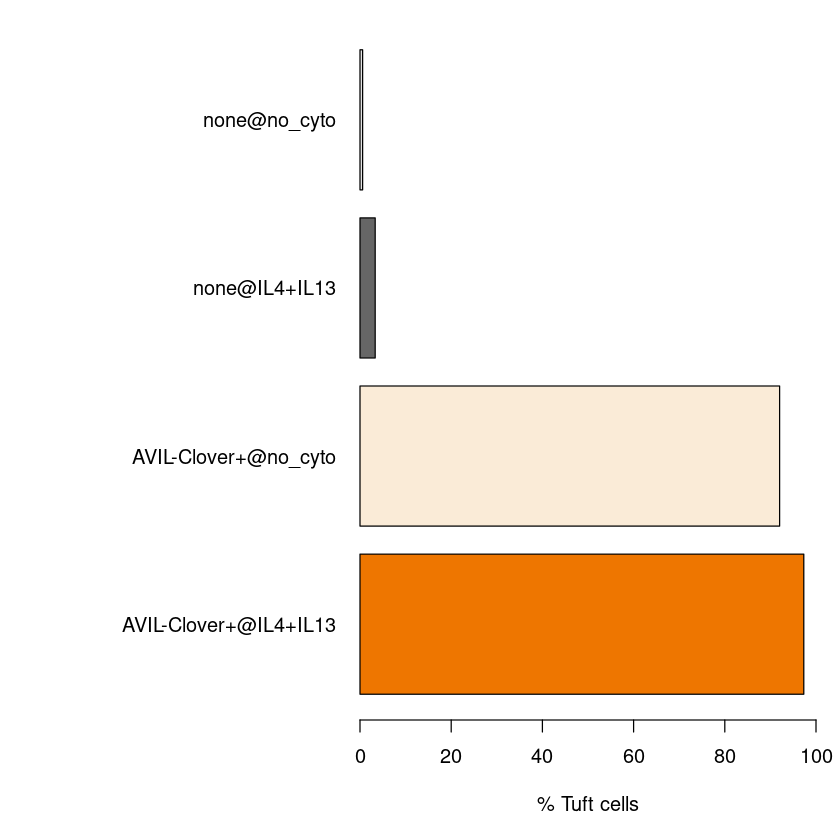

In [49]:
cell_stats = sc_mat@cell_metadata[ names(sc_cl@mc),]
comb = paste0(cell_stats$gating, "@", cell_stats$treatment)
names(comb) = rownames(cell_stats)

tuft_cells = names(sc_names)[ sc_names %in% tuft_pops]

X = table(comb, names(comb) %in% tuft_cells)
Xn = X / rowSums(X) * 100

p = function() {
    par(mar = c(5,15,1,1))
    barplot(Xn[,2], las=2, horiz=T, xlab = "% Tuft cells", axes = F, xlim = c(0,100), col = cols, space = 0.2)
    axis(1)
}

p()
pdf(paste0(outdir, "/ExtFig4b.pdf"), useDingbats = F)
p()
dev.off()
